# DABN13 - Assignment 4

## Preamble: Predicting competitor airfares on new routes

Air carriers regularly update their destination network and a necessary condition for adding a new flight connection to the existing network is that flights on this route are profitable. In addition to costs, profitability is determined by the price at which competitors could cater to the demand for flight transportation between two locations. A data-driven way of determining this would be on the basis of a supervised learning algorithm that has been trained on the fares for existing flight connections and which leverages information about route-specific characteristics. The dataset that we are using in this lab contains such information for more than 600 flight connections between different American cities. More specifically, we have information on the number of required stops, the market concentration on a particular route, Holiday destination status and a number of other characteristics that are detailed on [p.7 in the `mlba` library documentation](https://github.com/gedeck/mlba/blob/main/mlba_2.0.0.pdf). In the following, we will train and tune different supervised learning models that predict the average fare for a flight.


Before conducting the first part of this assignment, let's load our data.

In [1]:
import numpy as np # test comment
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings

Airfares = pd.read_csv("Airfares.csv.gz") # Adjust file path if necessary
Airfares = Airfares.drop(columns=["S_CODE", "S_CITY", "E_CODE", "E_CITY"])

Airfares.head() # bransch test

,COUPON,NEW,VACATION,SW,HI,S_INCOME,E_INCOME,S_POP,E_POP,SLOT,GATE,DISTANCE,PAX,FARE
0,1.00,3,No,Yes,5291.99,28637.0,21112.0,3036732,205711,Free,Free,312,7864,64.11
1,1.06,3,No,No,5419.16,26993.0,29838.0,3532657,7145897,Free,Free,576,8820,174.47
2,1.06,3,No,No,9185.28,30124.0,29838.0,5787293,7145897,Free,Free,364,6452,207.76
3,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Controlled,Free,612,25144,85.47
4,1.06,3,No,Yes,2657.35,29260.0,29838.0,7830332,7145897,Free,Free,612,25144,85.47


In [2]:
Airfares.shape # Looking at the dimensions

(638, 14)

## Part one: Ridge regression with scikit-learn
Ridge regression is supported in the `linear_models` module of scikit-learn. However, instead of using the `Ridge()`-function in this module, we are going to work with `ElasticNet()` because this function leads to ridge regression and the lasso as special cases. 

### Task 1a)
`sklearn` requires us to provide output and inputs separately as data frames containing numerical variables that can be directly put into a cost minimization problem. Provide that by conducting the following steps:

1. Save *all* predictors in `Airfares` as a Pandas dataframe `X_1a`. Then, use the `get_dummies()` function in Pandas to turn categorical variables into category dummies. Ensure that the first category of every categorical variable is dropped.
2. Save the output variable *FARE* as pandas series `y_1a`
3. Use the  `train_test_split()` function in the model selection module of `sklearn` to split `X_1a` (`y_1a`) into training data `X_train_1a` (`y_train_1a`) and test data `X_test_1a` (`y_test_1a`).

In [3]:
# 1. # First save all predictors from Airfares as X_1a as a pandas dataframe
X_1a = Airfares.drop(columns=["FARE"])
X_1a = pd.get_dummies(X_1a)

# 2. 
y_1a = Airfares["FARE"]

# 3.
from sklearn.model_selection import train_test_split

X_train_1a, X_test_1a, y_train_1a, y_test_1a = train_test_split(X_1a, y_1a, test_size=0.2, random_state=42)

In [14]:
print(f'training_data has shape: {X_train_1a.shape} \
      \ntest_data has shape: {X_test_1a.shape}')

training_data has shape: (510, 17)       
test_data has shape: (128, 17)


597    182.56
328    335.55
363    186.28
231    159.71
210     87.80
Name: FARE, dtype: float64

### Task 1b)
With a little effort, we can use `sklearn` to plot the relation between learned model coefficients and the regularization parameter.
Unlike other estimator functions in `sklearn`, we the coefficient path cannot be obtained by simply fitting a specified pipeline. We need to conduct all steps in that potential pipeline manually. 

1. First, we manually do more data transformations. We want to expand the set of input variables by adding interactions of all original inputs to the data set. The function `PolynomialFeatures()` does that for us. Use this function to specify a transformation `poly2_spec_1b` which adds interactions between any two input variables to the data. Do not add squared terms and no constant neither.
2. We can even use the `Pipeline()` function without an estimator, e.g. do specify a sequence of transformations. Create such a pipeline `X_transform_pipe_1b`. Its should contain `poly2_spec_1b` as its first step and standardization of all variables in the dataset (via `StandardScalar()` as its second step)
3. Use the `fit_transform()`-method on `X_transform_pipe_1b` to transform `X_train_1a` and save the result as `X_train_transformed_1b`
4. Use the `enet_path()` function to learn the sequence of ridge regression parameters for the sequence of regularization parameter values `lambdas_1b` that I defined below. You will need to specify your model inputs and output, as well as the choice of `l1_ratio` which results in ridge regression. Save the result as `ridgepath_1b`. Then, run the provided code for plotting the coefficient path.

C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

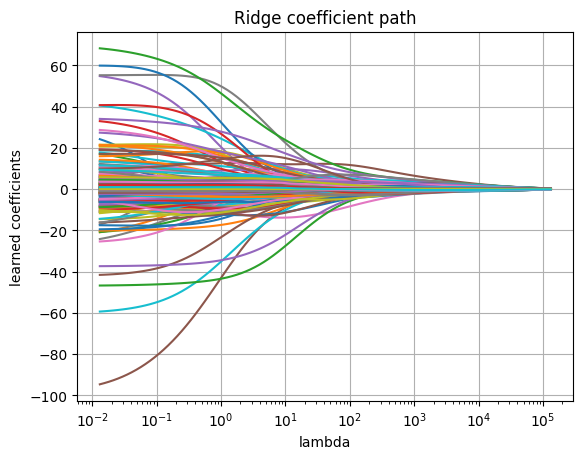

In [18]:
from sklearn.preprocessing import (StandardScaler, PolynomialFeatures)
from sklearn.pipeline import Pipeline
from sklearn.linear_model import enet_path

# 1.
poly2_spec_1b    = PolynomialFeatures(degree = 2, include_bias=False)

# 2.
X_transform_pipe_1b = Pipeline([
    ("poly2", poly2_spec_1b),
    ("scaler", StandardScaler())
])

# 3.
X_train_transformed_1b = X_transform_pipe_1b.fit_transform(X_train_1a)

# 4.
lambdas_1b = (np.logspace(7, 0, 100)/(y_train_1a.std(ddof=1)*2 * y_train_1a.shape[0]))

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    ridgepath_1b    = enet_path(X_train_transformed_1b, y_train_1a, l1_ratio=0, eps=0.0001, alphas=lambdas_1b)


# Run the lines below for a plot of the coefficient path
ax = plt.gca()
for i in range(ridgepath_1b[1].shape[0]):
    plt.plot(ridgepath_1b[0]*y_train_1a.shape[0]*2, ridgepath_1b[1][i])

ax.set_xscale("log")
plt.xlabel("lambda")
plt.ylabel("learned coefficients")
plt.title("Ridge coefficient path")
plt.axis("tight") 
plt.grid(True)   

plt.show()


### Task 1c)
Now that we have inspected the coefficient path for ridge regression, we want to find an optimal tuning parameter value via K-fold cross-validation. This works almost exactly as in Assignment 3.

1. Specify a pipeline that contains the two transformations that we already specified in `X_transform_pipe_1b` as well as a ridge regression specification (use `Ridge()`). Save the specified pipeline as `ridge_pipe_1c`. 

2. Put the set of tuning parameter candidates `lambdas_1c` below into a dictionary object `tune_grid_1c` that `GridSearchCV()` can handle when estimation function is the pipeline `ridge_pipe_1c`.

3. Use the `KFold()`-function to specify a **random** partition into five folds. Set the `random_state` to 5 for the sake of replicability.

4. Do 5-fold cross-validation to determine the optimal regularization parameter value among the candidates in `lamndas_1b` by calling the `GridSearchCV()`-function. Use the pipeline and the split specified in the previous two steps. Measure prediction performance with (negative) mean squared error. Save the resulting object as `ridge_tune_1c`.
5. Save the `cv_results_` object in `ridge_tune_1c` as `ridge_cv_out_1c`.

In [32]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import (KFold, GridSearchCV)

# 1.
ridge_pipe_1c  = Pipeline(steps = [
    ("poly2", poly2_spec_1b),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

# 2.
lambdas_1c = np.logspace(7, 0, 100)/(y_train_1a.std(ddof=1))
tune_grid_1c = {"ridge__alpha": lambdas_1c}

# 3.
cv_splits_1c = KFold(n_splits=5, shuffle=True, random_state=5) # Why 42? It says 5 in description

# 4.
ridge_tune_1c   = GridSearchCV(ridge_pipe_1c, tune_grid_1c, cv=cv_splits_1c, return_train_score=True, n_jobs=-1, scoring="neg_mean_squared_error")
ridge_tune_1c.fit(X_train_1a, y_train_1a)

# 5.
ridge_cv_out_1c = ridge_tune_1c.cv_results_ # Why using pd.Dataframe? I think it changes the object type



C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

### Task 1d) 
In the code block below, you will find a function `elnet_cvplot_1d` which plots cross-validation errors together with bands at a distance of one standard deviation. It also indicates the position of the tuning parameter value with minimal cross-validation error and of the value that would be chosen according to the one-S.E. rule. The function is almost complete - you only need to do the following:

1. Ensure that the object `min_error_index` contains the index of the tuning parameter leading to the smallest cross-validation error. `argmin()` in NumPy does that for you.
2. Allocate to `one_se_rule_index` the index of the tuning parameter value that would be chosen according to the one-standard error rule. You could do that by using the NumPy function `where()` to ask which cross-validation errors are smaller than the minimum cross-validation error plus one standard error. The first element in the resulting array should contain the index that you are looking for.
3. Create a dictionary object `best_lams` with elements "lambda_min" and "lambda_1se" which contain the values of the tuning parameter suggested by minimum cross-validation error and the one-S.E. rule, respectively. Tell your python function to return `best_lams`.


In [65]:

def elnet_cvplot_1d(lambdas, cv_errors, std_errors):
    """
    Inputs:
    - lambdas: Array of tuning parameter values.
    - cv_errors: Array of cross-validation errors corresponding to tuning parameters.
    - std_errors: Array of standard errors of cross-validation errors.
    """
    # Do not change anything in the following six lines
    sort_idx   = np.argsort(lambdas)
    lambdas    = lambdas[sort_idx]
    cv_errors  = cv_errors[sort_idx]
    std_errors = std_errors[sort_idx]
    
    
    plt.figure(figsize=(10, 6))
    plt.plot(lambdas, cv_errors, linestyle='-', color='blue', label='CV Error')
    
    upper_band = np.array(cv_errors) + np.array(std_errors)
    lower_band = np.array(cv_errors) - np.array(std_errors)
    plt.fill_between(lambdas, lower_band, upper_band, color='gray', alpha=0.6, label='±1 SE')

    # 1.
    min_error_index = np.argmin(cv_errors) # here we needed input, I added a minus sign in the call since we work with neg_mse
    plt.axvline(x=lambdas[min_error_index], color='gray', linestyle='--', label='Min Error')

    # 2.
    # This goes through all cv-errors <= the min + 1 se and grabs the last one
    one_se_rule_index = np.where(cv_errors <= cv_errors[min_error_index] + std_errors[min_error_index])[0][-1]
    plt.axvline(x=lambdas[one_se_rule_index], color='gray', linestyle=':', label='1SE rule')
    
    # Do not change the seven lines below
    plt.xscale('log')
    plt.xlabel('Regularization parameter values')
    plt.ylabel('Cross-Validation error')
    plt.title('Cross-Validation Error with One Standard Error Bands')
    plt.legend()
    plt.grid(True)   
    plt.show()

    # 3.
    best_lams = {'lambda_min': lambdas[min_error_index], 'lambda_1se': lambdas[one_se_rule_index]} # I think this is it
    return(best_lams)

### Task 1e) 
Call the function `elnet_cvplot_1d` in order to obtain a plot of tuning parameter values against cross-validation error. Save the result as `ridge_best_lambdas_1e`. The arrays of cross-validation errors and their standard errors are saved inside `ridge_cv_out_1c`. Choose them correctly when calling `elnet_cvplot_1d` and make sure that your cross-validation errors are positive numbers.

Lastly, judging from the regularization path from Task 1b, how much are the learned model coefficients shrunk to zero relative to a linear regression model without regularization? Save your answer as string variable `regularization_amount_1e`

36
56


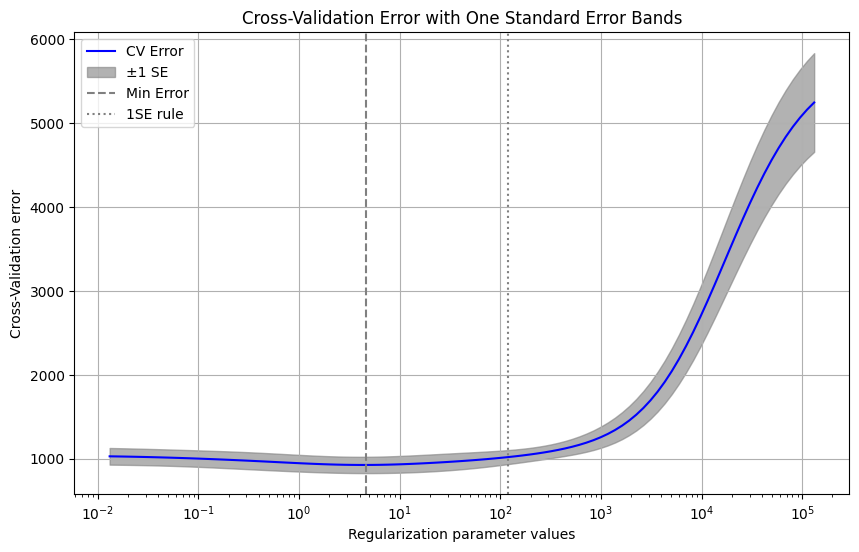

The min error is found at lambda: 4.619343356789786    
The lambda corresponding to one se rule is: 119.87307851638016


In [70]:
ridge_best_lambdas_1e = elnet_cvplot_1d(lambdas_1c, -ridge_cv_out_1c["mean_test_score"], ridge_cv_out_1c["std_test_score"])
regularization_amount_1e = f'The min error is found at lambda: {ridge_best_lambdas_1e["lambda_min"]}\
    \nThe lambda corresponding to one se rule is: {ridge_best_lambdas_1e["lambda_1se"]}'
print(regularization_amount_1e)

### Task 1f) 
Now, we want to get test set predictions for ridge regression with tuned regularization parameter. To arrive there, do the following:

1. Fit ridge regression with your personal favorite among the minimum-MSE or one-S.E. tuning parameter values. This merely requires you to specifiy a modified version of `ridge_pipe_1c` and to apply the `fit()`-method to the resulting pipeline. Save the learned model as `ridge_fit_1f`.
2. Apply the `predict()` method to `ridge_fit_1f` in order to get output predictions for all data points in `X_test_1a`. Save them as `yhat_test_ridge_1f`.


In [82]:
# 1.
ridge_fit_1f  = Pipeline(steps = [
    ("poly2", poly2_spec_1b),
    ("scaler", StandardScaler()),
    ("ridge", Ridge(alpha=ridge_best_lambdas_1e['lambda_1se']))]).fit(X_train_1a, y_train_1a) # Might this be it?
# 2.
yhat_test_ridge_1e  = ridge_fit_1f.predict(X_test_1a) # Predictions look pretty nice if you print them


C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed

## Part 2: Lasso with scikit-learn

In this slightly more difficult section, we are going to repeat Part 1 for the lasso and improvise a little with the model specification.


### Task 2a)

Repeat Tasks 1c, 1e and 1f, albeit for the lasso instead of ridge regression. That is, do the following:

1. Specify a pipeline for the lasso. Save as `lasso_pipe_2a`
2. Turn the provided array of tuning parameter candidates `lambdas_2a` into a tuning grid that works with `lasso_pipe_2a`. Save as `tune_grid_2a`
3. Conduct cross-validation. You can reuse the splitter `cv_splits_1c`. Save as `lasso_tune_2a`.
4. Extract detailed cross-validation results into `lasso_cv_out_2a`.
5. Call `elnet_cvplot_1d` and save results as `lasso_best_lambdas_1e`. Decide whether minimum-MSE or one-S.E. choice is most suitable and explain shortly in the string variable `bestlambda_lasso_2a`.
6. Set up a pipeline for Lasso with your optimal regularization parameter and learn this model in the training data. Save as `lasso_fit_2a`.
7. Obtain test data predictions `yhat_test_lasso_2a`.


In [ ]:
from sklearn.linear_model import (ElasticNet, Lasso)


# 1.
lasso_pipe_2a = ??

# 2.
lambdas_2a = 10**np.linspace(2,-3)
tune_grid_2a = ??

# 3.
lasso_tune_2a   = ??
??

# 4.
lasso_cv_out_2a  = ??

# 5. 
lasso_best_lambdas_2a  = ??

# 6. 
lasso_fit_2a = ??
bestlambda_lasso_2a = "??"

# 7.
yhat_test_lasso_2a =??


### Task 2b)

The performance of regularized linear regression models crucially depends on which input variables we use. We already exploited this fact by adding interactions between any two variables in `X_train_1a` to our model inputs. Now, we additionally use the principal components of the original data and therefore create a hybrid between regularization and dimension reduction. 

Our key tool in `sklearn` for this task is be the `FeatureUnion()` function. It is specified like a pipeline, but it does not *sequentially* apply the transformations that it consists of. Instead `FeatureUnion()` executes the transformations in parallel and combines their output. 

Now conduct the following steps:

1. Create a pipeline `pca_pipe_2b` which obtains all principal components of the data it is fit on. In addition to conducting PCA, the pipeline should standardize the data before **and** after getting principal components. `pca_pipe_2b` is a pipeline for pure variable transformation, just as `X_transform_pipe_1b` in Task 1b was.
2. Use the `FeatureUnion()` to combine the pipelines `X_transform_pipe_1b` and `pca_pipe_2b` and save the resulting specification as `combined_transform_2b`.
3. Write a pipeline that conducts the data transformation `combined_transform_2b` and which subsequently trains a lasso model. Save this pipeline as `lasso_pipe_2b`.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import FeatureUnion

# 1.
pca_pipe_2b = ??

# 2.
combined_transform_2b = FeatureUnion(??)

# 3.
lasso_pipe_2b = ??



### Task 2c)
Run 5-fold cross-validation as in Task 2a when you created the object `lasso_tune_2a`. However, use your new pipeline `lasso_pipe_2b` as estimator. Save the resulting object as `lasso_tune_2c`. 

Then, let's skip the process of looking at the curve of cross-validation errors and of deciding between minimum MSE and one-S.E. tuning parameter values. Once fitted, an object created with `GridSearchCV()` allows you to directly get predictions from the model with tuning parameter that minimizes cross-validation error. You only need to apply the `predict()` method to this object. Do this now in order to get output predictions for the test inputs `X_test_1a`. Save your predictions as `yhat_test_lasso_2c`

In [ ]:
lasso_tune_2b = ??
??
yhat_test_lasso_2b = ??


### Task 2d 
Lasso performs variable selection in addition to shrinkage. For this reason, we move outside our prediction-centered machine learning bubble for a second and have a look at the input variables that are included in our chosen lasso model from Task 2c. 

The model with best tuning parameter is saved as an attribute in `lasso_tune_2b`. Look up in the [GridSearchCV documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) which attribute that is and save it as an object `lasso_fit_2d`.

The learned coefficients of the lasso model are saved as an attribute inside `lasso_fit_2d`. Look up the documentation for [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (depending on which function you used) to identify the correct attribute. Then, note that your estimator is an entire pipeline. For that reason, address the last step of this pipeline (by name) and save the attribute which contains its learned coefficients as a new object `lasso_coefs_2d`.

In [ ]:
lasso_fit_2d = ??

lasso_coefs_2d = ??

# Run the four lines below to match variable names with coefficient values.
poly_feature_names  = X_transform_pipe_1b['poly2'].get_feature_names_out(input_features=X_train_1a.columns)
pca_component_names = [f'PC{idx}' for idx in range(1, X_train_1a.shape[1] + 1)]
all_feature_names   = np.concatenate([poly_feature_names, pca_component_names])
lasso_coefs_2d      = pd.DataFrame({'Variable': all_feature_names, 'Coefficient': lasso_coefs_2d})
print(lasso_coefs_2d)

## Part 3: Elastic net and overall performance evaluation

Now that we successfully tuned both ridge regression and the lasso, doing the same for the elastic net is very simple. 

### Task 3a)

Conduct the following tasks to set up your cross-validation setup

1. Create a pipeline with the same setup as in `ridge_pipe_1c` or `lasso_pipe_2a` except for specifying the elastic net in the last step. Save the object as `elnet_pipe_3a`.
2.  Create a dictionary `tune_grid_3a` concerning candidate values of your two tuning parameters. The names of this dictionary should be chosen so that they work with `elnet_pipe_3a`. The candidate values for the regularization parameter can be those saved in `lambdas_2a`. For the `l1_ratio` parameter that weights l1- and l2-penalties, choose six values from 0 to 1 with equal distance to each other.   

In [ ]:
# 1.
elnet_pipe_3a = ??
# 2.
tune_grid_3a = ??

### Task 3b)
The two objects created in Task 3a are all inputs to `GridSearchCV()` that are specific to elastic net. 

First, specify and fit an object `elnet_tune_3b` with `GridSearchCV()`. The criterion for predictive accuracy and the split into five folds should be the same as before.

Second, look in the [GridSearchCV() documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) for the attribute in `elnet_tune_3b` which contains the best tuning parameter values. Save this attribute as `tune_elnet_best_3b`. Do the chosen tuning parameter values result in a model that leans more into the direction of ridge regression or more towards the lasso? Write a well-motivated answer into the string variable `interpret_tune_3b`

Third, get predictions for the test inputs `X_test_1a` from `elnet_tune_3b` (i.e. from the model that leads to minimum cross-validation error). Save them as 



In [ ]:
# 1.
elnet_tune_3b = ??
??

# 2.
tune_elnet_best_3b = ??
interpret_tune_3b = "??"

# 3.
yhat_test_elnet_3b = ??

### Task 3c) 

We have now obtained predictions on test data for four different versions of the elastic net. It is time to find out which of them performs best. Use the observed test outcomes `y_test_1a` to calculate the mean squared error for all `yhat_test`-objects that we have created so far. You can calculate MSE manually or use the `mean_squared_error` function in the metrics module of `sklearn`. Save them as `MSE_` plus the name of the method that we used previously.

Which one among the four candidate algorithms is superior? Write your conclusion and some details about the margin between the best and the remaining algorithms in the string variable `conclusion_3c` 

In [ ]:
from sklearn.metrics import mean_squared_error

MSE_ridge   = ??
MSE_lasso_a = ??
MSE_lasso_b = ??
MSE_elnet   = ??

conclusion_3c = "??"

## Part 4: Manual cross-validation for ridge regression

In this really advanced part, we are going to manually conduct the grid search over tuning parameter values that `GridSearchCV()` automatically provides us with. We are going to find the optimal tuning parameter for ridge regression. The learning goal of this part is to realize what a gigantic mess machine learning life is without `sklearn` (or similar libraries).

### Task 4a)
Write a function `ridge_testMSE_4a` that takes the following inputs:

- `Xtrain`: training inputs
- `ytrain`: training output
- `Xtest`:  test inputs
- `ytest`:  test outputs
- `lam`:    tuning parameter value

The function is supposed to do the following: 
1. Set the current tuning parameter value `lam` as the `alpha`-argument of your ridge regression estimator in `ridge_pipe_1c`. The `set_params()`-method allows you to do this. The name of the `alpha` argument must be specified as `xyz__alpha` where you **replace xyz** with the name that you gave the ridge regression step in `ridge_pipe_1c`.
2. Fit the pipeline `ridge_pipe_1c` from Part 1 on the training data. Specify the current tuning parameter value `lam` as an additional argument to the fit-method. 
3. Use the fitted model to predict outputs for the test inputs.
4. Calculate the MSE and return it as function output.



In [ ]:
??

### Task 4b)
Write a function `ridge_testMSE_grid_4b` that takes the same inputs as `ridge_testMSE_4a` except that it takes an entire array of tuning parameter values `lam_grid` instead of one value `lam`. For each value in `lam_grid` it gets test MSE from `ridge_testMSE_4a`. The entire NumPy array of test MSEs is then returned as function output.



In [ ]:
??

### Task 4c)

Write a function `ridge_kfolderr_4c` that takes the following inputs:

- `X`: a matrix of model inputs,
- `y`: a vector of model outputs,
- `lamgrid:`a vector of tuning parameter values,
- `batchid`: A vector that specifies to which batch a particular data point belongs to.

`ridge_kfolderr_4c` should first identify $K$ as the maximum value in `batchid`. Then it should loop over the values $1,2,\ldots,K$. At iteration $k$, the loop should do the following:

1. Set `X_train` (`y_train`) as all data points in `X` (`y`) that do *not* belong to batch $k$,
2. Set `X_test` (`y_test`) as all data points in `X` (`y`) that *belong* to batch $k$.
3. Call `ridge_testMSE_grid_4c` for the given split into training and test batches to get test MSEs for the entire vector `lamgrid`.

Once the loop has finished, the test MSEs of all $K$ iterations should be averaged. The resulting vector of k-fold cross-validation errors should be the function output.



In [ ]:
??

### Task 4d)

Below, I specify `lamgrid_4d`, a grid of potential values for $\lambda$, as well as `batches_4d`, an allocation of data points to batches. Do the following: 

1. Use `ridge_kfolderr_4c` with these inputs as well as `y_train_1a` and `X_train_1a` to get k-fold CV errors for every tuning parameter value in `lamgrid_4d`. Save this object as `kfolderrs_4d`,
2. Use `which.min()` to extract the index of the smallest k-fold CV value in `kfolderrs_4d` into a new object `minindex_4d`,
3. Save the k-fold CV error at index `minindex_4d` of `lamgrid_4d` as `best_lambda_4d`.


In [ ]:
??